<h1 style="font-size:3em; text-align: center">Multi-Step Forecasting With Facebook's Prophet</h1>


In [78]:
# imports
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras        import backend as K
from datetime     import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from matplotlib.pylab      import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 6
# fixes the random number seed to ensure reproducible results
np.random.seed(69)

# number of inputs to be fed
look_back = 288
# number of outputs to be generated
look_forward = 24

In [224]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5500)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)


# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

In [292]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

# split into train and test sets
train_size = 288*10
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [293]:
def predictNext2Hours (model, dataset):
    dataset = np.array(dataset)
    # log then normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = dataset.transpose()
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
    # reshape the dataset
    data = dataset.T
    data = data.reshape(1, 1, data.shape[0])
    # make a prediction
    prediction = model.predict(data)
    # un-normalize the data set
    prediction = scaler.inverse_transform(prediction)
    return prediction

def predict (day=11, total_days=1, delta=1, show_gradual_error=True):
    predictions = np.array([])
    true_vals = np.array([])
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back)).reshape(24)
        # plots the predictions
        plt.plot(range(point, point+24),prediction, color="red", alpha=0.1)
        predictions = np.append(predictions, prediction)
        true_vals = np.append(true_vals,dataset_orig[i:i+24])
    predictions = predictions.reshape(len(predictions)/24, 24)
    true_vals = true_vals.reshape(len(true_vals)/24, 24)
    plt.plot(range(288*day,288*day+288*total_days),dataset_orig[288*day:288*day+288*total_days,0])
    plt.show()
    if show_gradual_error:
        err = np.array(range(24)).astype('float32')
        for i in range(look_forward):
            # calc RMSE
            #err[i] = math.sqrt(mean_squared_error(true_vals[:,i],predictions[:,i]))
            
            # calc individial errors
            indiv_err = true_vals[:,i] - predictions[:,i]
            plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
        plt.plot(err)
        plt.show()

Loss Function that Penalizes Over-Estimates Inspired from <br/>
https://datascience.stackexchange.com/questions/10471/linear-regression-with-non-symmetric-cost-function

Epoch 1/5
14s - loss: 0.0047
Epoch 2/5
8s - loss: 0.0028
Epoch 3/5
9s - loss: 0.0024
Epoch 4/5
9s - loss: 0.0023
Epoch 5/5
9s - loss: 0.0021


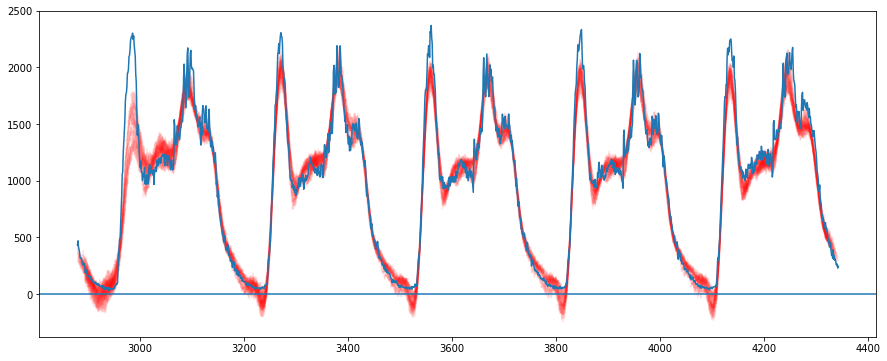

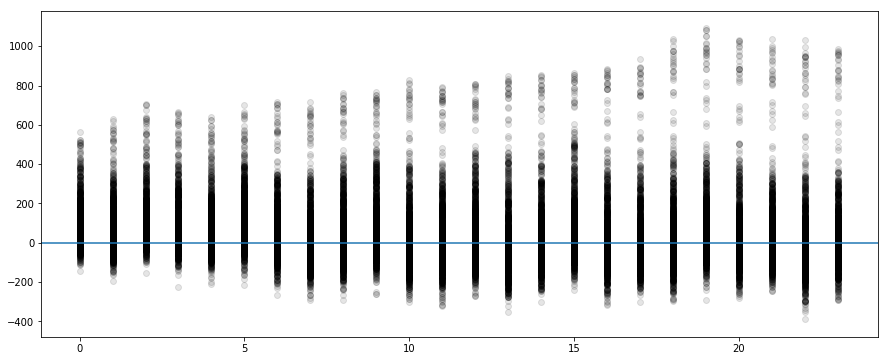

42.7893518519


In [81]:
look_forward = 24
look_back = 288
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5500)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# log the dataset
#dataset = np.log(dataset_orig)
#dataset_max = max(dataset)
# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)
# split into train and test sets
train_size = 288*10
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)
# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

def predictNext2Hours (model, dataset):
    dataset = np.array(dataset)
    # normalize
    dataset = dataset.transpose()
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
    data = (dataset.T)
    data = data.reshape(1, 1, data.shape[0])
    # make a prediction
    prediction = model.predict(data)
    prediction = scaler.inverse_transform(prediction)
    return prediction

def predict (day=11, total_days=1, delta=1, show_gradual_error=True):
    predictions = np.array([])
    true_vals = np.array([])
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back)).reshape(look_forward)
        # plots the predictions
        plt.plot(range(point, point+look_forward),prediction,color='red', alpha=0.1)
        predictions = np.append(predictions, prediction)
        true_vals  = np.append(true_vals,dataset_orig[point:point+look_forward])
    # Reshapes the predictions and true vals to calculate the error
    predictions = predictions.reshape(len(predictions)/look_forward, look_forward)
    true_vals   = true_vals.reshape(len(true_vals)/look_forward, look_forward)
    plt.plot( np.arange(288*total_days+look_forward) + 288 * day, dataset_orig[288*day:288*day+288*total_days + look_forward,0])
    plt.axhline(0)
    plt.show()
    if show_gradual_error:
        total = 0
        num_overestimating = 0
        for i in range(look_forward):
            # calc individial errors
            indiv_err = true_vals[:,i] - predictions[:,i]
            for j in range(len(indiv_err)):
                total += 1.0
                if (predictions[j, i] > true_vals[j, i]):
                    num_overestimating += 1.0
            plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
        print num_overestimating / total * 100
    
def over_penalty(y_true, y_pred):
    true_error = y_true - y_pred
    # doubles the error if the prediction is negative
    return  K.square(true_error) * K.square(K.sign(true_error) - 0.55) #* ( ( K.sign(y_pred) * (K.sign(y_pred) - 1) ) * 4.5 + 1 )

b = 1
seed = 11

np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(look_forward))
model.compile(loss=over_penalty, optimizer=keras.optimizers.RMSprop(lr=0.0002, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
predict(total_days=5,day=10,delta=1)

Epoch 1/5
17s - loss: 0.0149
Epoch 2/5
12s - loss: 0.0097
Epoch 3/5
12s - loss: 0.0086
Epoch 4/5
12s - loss: 0.0077
Epoch 5/5
12s - loss: 0.0072


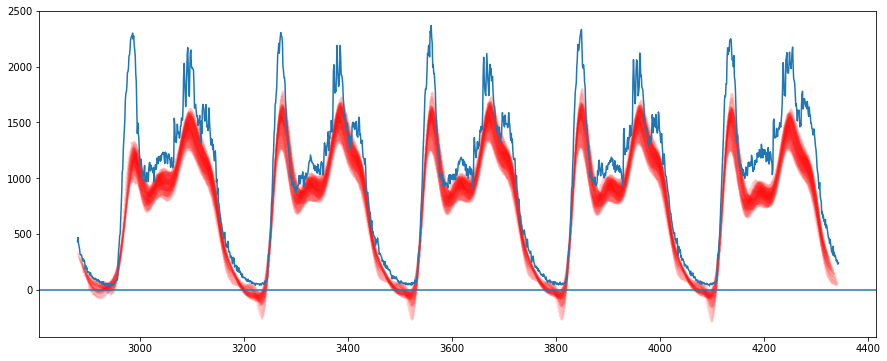

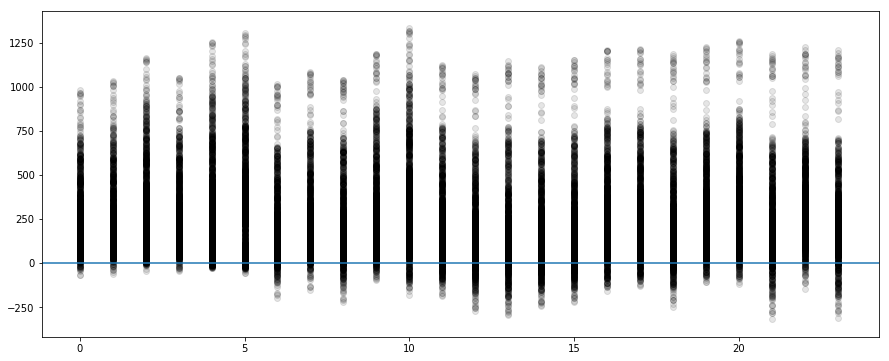

5.68287037037


In [102]:
look_forward = 24
look_back = 288
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5500)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# log the dataset
#dataset = np.log(dataset_orig)
#dataset_max = max(dataset)
# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)
# split into train and test sets
train_size = 288*10
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)
# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

def predictNext2Hours (model, dataset):
    dataset = np.array(dataset)
    # normalize
    dataset = dataset.transpose()
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
    data = (dataset.T)
    data = data.reshape(1, 1, data.shape[0])
    # make a prediction
    prediction = model.predict(data)
    prediction = scaler.inverse_transform(prediction)
    return prediction

def predict (day=11, total_days=1, delta=1, show_gradual_error=True):
    predictions = np.array([])
    true_vals = np.array([])
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back)).reshape(look_forward)
        # plots the predictions
        plt.plot(range(point, point+look_forward),prediction,color='red', alpha=0.1)
        predictions = np.append(predictions, prediction)
        true_vals  = np.append(true_vals,dataset_orig[point:point+look_forward])
    # Reshapes the predictions and true vals to calculate the error
    predictions = predictions.reshape(len(predictions)/look_forward, look_forward)
    true_vals   = true_vals.reshape(len(true_vals)/look_forward, look_forward)
    plt.plot( np.arange(288*total_days+look_forward) + 288 * day, dataset_orig[288*day:288*day+288*total_days + look_forward,0])
    plt.axhline(0)
    plt.show()
    if show_gradual_error:
        total = 0
        num_overestimating = 0
        for i in range(look_forward):
            # calc individial errors
            indiv_err = true_vals[:,i] - predictions[:,i]
            for j in range(len(indiv_err)):
                total += 1.0
                if (predictions[j, i] > true_vals[j, i]):
                    num_overestimating += 1.0
            plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
        print num_overestimating / total * 100
    
def over_penalty(y_true, y_pred):
    true_error = y_true - y_pred
    # doubles the error if the prediction is negative
    return  K.square(true_error) * K.square(K.sign(true_error) - 0.55) #* ( ( K.sign(y_pred) * (K.sign(y_pred) - 1) ) * 4.5 + 1 )

b = 1
seed = 11
rate = 0.3
np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(Dropout(rate, input_shape=(1, look_back)))
model.add(LSTM(256, recurrent_dropout=0.3))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dense(look_forward))
model.compile(loss=over_penalty, optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
predict(total_days=5,day=10,delta=1)

In [99]:
predictNext2Hours(model, dataset_orig[288*10:288*11])

array([[ 288.9699707 ,  275.5647583 ,  269.00674438,  244.97894287,
         225.11181641,  214.56967163,  200.56060791,  198.24429321,
         181.894104  ,  175.32112122,  149.54309082,  143.12695312,
         140.63890076,  124.52850342,  114.52770233,  112.59513092,
          89.75230408,  101.65592194,   98.00193024,   77.41026306,
          92.78258514,   86.10972595,   74.79251862,   89.85277557]], dtype=float32)

In [139]:
f = K.function([model.layers[0].input, K.learning_phase()],
               [model.layers[-1].output])

def predict_with_uncertainty(f, x, n_iter=10):
    result = np.zeros((n_iter,) + x.shape)
    for iter in range(n_iter):
        result[iter] = f([x, 1])

    prediction = result.mean(axis=0)
    uncertainty = result.var(axis=0)
    return prediction, uncertainty


In [140]:
predict_with_uncertainty(f, np.array(dataset_orig[288*10:288*11]) )

ValueError: Cannot feed value of shape (288, 1) for Tensor u'dropout_28_input:0', which has shape '(?, 1, 288)'

NameError: name 'self' is not defined

In [34]:
look_forward = 6

# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5500)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# log the dataset
#dataset = np.log(dataset_orig)
#dataset_max = max(dataset)
# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

# split into train and test sets
train_size = 288*7
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

def predictNext2Hours (model, dataset):
    dataset = np.array(dataset)
    # log then normalize the dataset
    #dataset = np.log(dataset)
    # normalize
    
    # scaler = MinMaxScaler(feature_range=(0, 1))
    
    dataset = dataset.transpose()
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
    
    data = (dataset.T)
    data = data.reshape(1, 1, data.shape[0])
    # make a prediction
    prediction = model.predict(data)
    
    prediction = scaler.inverse_transform(prediction)
    
    #prediction = np.exp(prediction)
    
    return prediction

def predict (day=11, total_days=1, delta=1, show_gradual_error=True):
    predictions = np.array([])
    true_vals = np.array([])
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back)).reshape(look_forward)
        # plots the predictions
        plt.plot(range(point, point+look_forward),prediction,color='red', alpha=0.5)
        predictions = np.append(predictions, prediction)
        true_vals  = np.append(true_vals,dataset_orig[point:point+look_forward])
        
    # Reshapes the predictions and true vals to calculate the error
    predictions = predictions.reshape(len(predictions)/look_forward, look_forward)
    true_vals   = true_vals.reshape(len(true_vals)/look_forward, look_forward)

    plt.plot( np.arange(288*total_days+look_forward) + 288 * day, dataset_orig[288*day:288*day+288*total_days + look_forward,0])
    
    plt.axhline(0)
    
    plt.show()
    if show_gradual_error:
        
        for i in range(look_forward):
            # calc individial errors
            indiv_err = true_vals[:,i] - predictions[:,i]
            plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
    

def over_penalty(y_true, y_pred):
    true_error = y_true - y_pred
    # doubles the error if the prediction is negative
    return  K.square(true_error) * K.square(K.sign(true_error) - 0.1) #* ( ( K.sign(y_pred) * (K.sign(y_pred) - 1) ) * 4.5 + 1 )

np.random.seed(6)

# create and fit the LSTM network
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(look_back,), dtype='float32', name='main_input')





#model = Sequential()
#model.add(LSTM(32, input_shape=(1, look_back)))
#model.add(Dense(64))
#model.add(Dense(64))
#model.add(Dense(64))
#model.add(Dense(look_forward))
#model.compile(loss=over_penalty, optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))
#model.compile(loss=over_penalty, optimizer='adam')
#model.compile(loss='mean_squared_error', optimizer='adam')

#model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)
#predict(delta=1)

Epoch 1/5
5s - loss: 0.0658
Epoch 2/5
1s - loss: 0.0372
Epoch 3/5
1s - loss: 0.0328
Epoch 4/5
1s - loss: 0.0304
Epoch 5/5
1s - loss: 0.0297


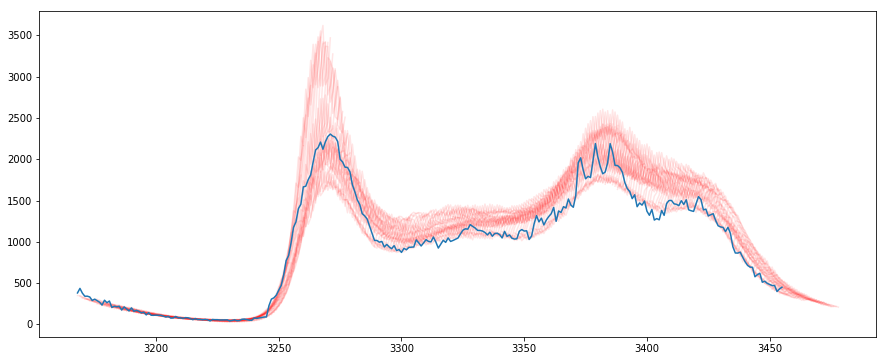

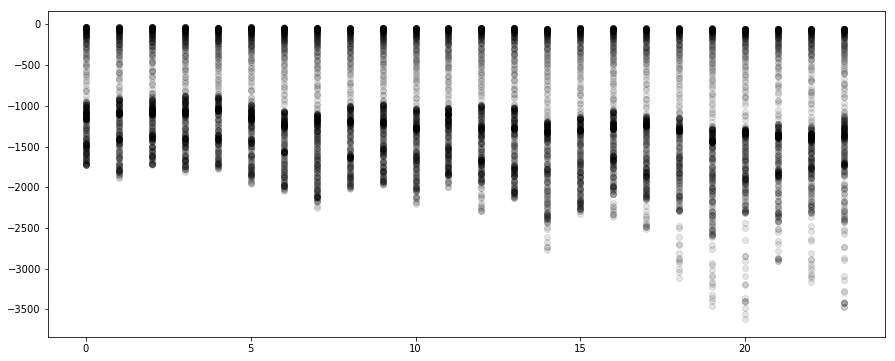

In [345]:
### np.random.seed(6)

# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5500)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# log the dataset
dataset = np.log(dataset_orig)
dataset_max = max(dataset)
# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = 288*7
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

def predictNext2Hours (model, dataset):
    dataset = np.array(dataset)
    # log then normalize the dataset
    dataset = np.log(dataset)
    # normalize
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = dataset.transpose()
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
    
    data = (dataset.T)
    data = data.reshape(1, 1, data.shape[0])
    # make a prediction
    prediction = model.predict(data)
    
    prediction = scaler.inverse_transform(prediction)
    
    prediction = np.exp(prediction)
    
    return prediction

def predict (day=11, total_days=1, delta=1, show_gradual_error=True):
    predictions = np.array([])
    true_vals = np.array([])
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back)).reshape(24)
        # plots the predictions
        plt.plot(range(point, point+24),prediction, color="red", alpha=0.1)
        
        predictions, true_vals = np.append(predictions, prediction), np.append(true_vals,dataset[i:i+24])
    # Reshapes the predictions and true vals to calculate the error
    predictions, true_vals = predictions.reshape(len(predictions)/24, 24), true_vals.reshape(len(true_vals)/24, 24)
    plt.plot( np.arange(288 * total_days) + 288 * day, dataset_orig[288*day:288*day+288*total_days,0])
    plt.show()
    if show_gradual_error:
        for i in range(look_forward):
            # calc individial errors
            indiv_err = true_vals[:,i] - predictions[:,i]
            plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
        # plt.plot(err)
        plt.show()

def over_penalty(y_true, y_pred):
    true_error = y_true-y_pred
    return K.sqrt(K.square(true_error) * K.square(K.sign(true_error) - 0.4))

# create and fit the LSTM network
np.random.seed(1)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(look_forward, input_shape=(1, look_back)))
model.add(Dense(look_forward*3))
model.add(Dense(look_forward))
model.compile(loss=over_penalty, optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=3, verbose=2)
predict()

Epoch 1/5
9s - loss: 0.0016
Epoch 2/5
6s - loss: 2.2652e-05
Epoch 3/5
6s - loss: 1.3955e-05
Epoch 4/5
6s - loss: 9.1886e-06
Epoch 5/5
6s - loss: 6.3856e-06
Epoch 1/1
6s - loss: 4.8667e-06


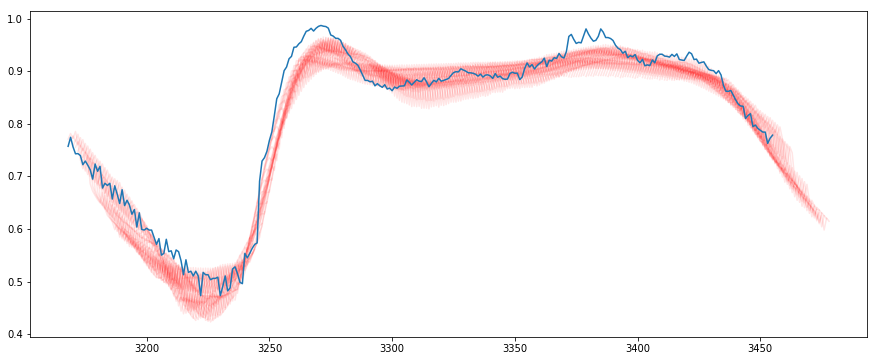

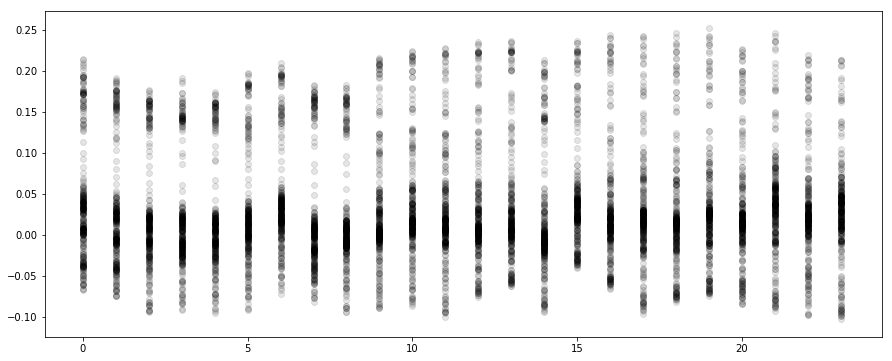

In [316]:





np.random.seed(6)

def over_penalty(y_true, y_pred):
    return K.square(y_true-y_pred)*K.square(K.sign(y_true-y_pred) - 0.4) 

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(look_forward, input_shape=(1, look_back)))
model.add(Dense(look_forward))
model.compile(loss=over_penalty, optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)
predict()

Epoch 1/5
5s - loss: 0.0063
Epoch 2/5
3s - loss: 0.0026
Epoch 3/5
3s - loss: 0.0022
Epoch 4/5
3s - loss: 0.0020
Epoch 5/5
3s - loss: 0.0019
243.10 RMSE


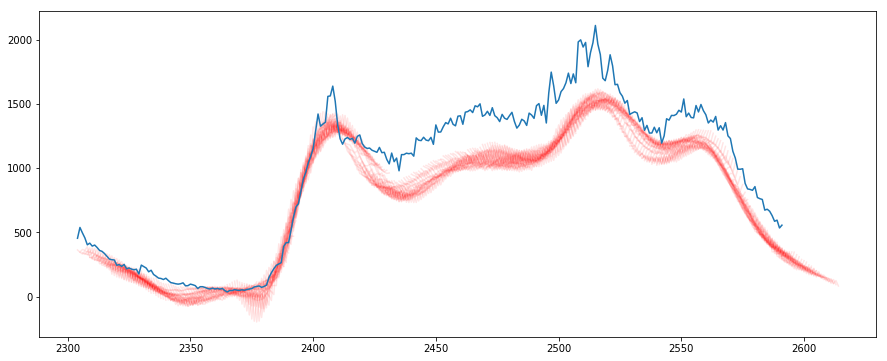

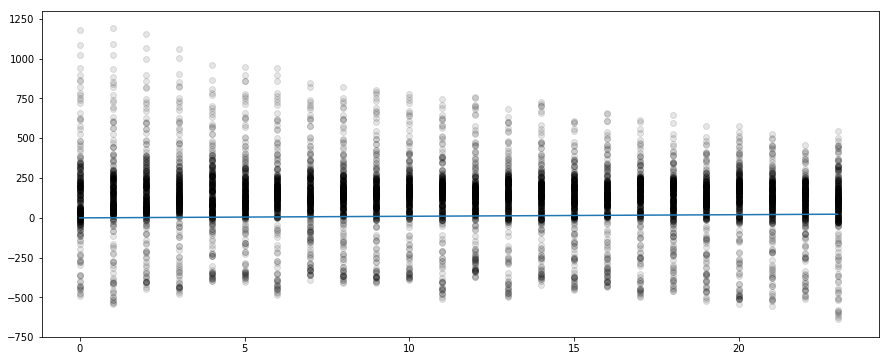

In [244]:
np.random.seed(6)

def over_penalty(y_true, y_pred):
    return K.square(y_true-y_pred)*K.square(K.sign(y_true-y_pred) - 0.6)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(1, look_back)))
model.add(Dense(look_forward))
model.compile(loss=over_penalty, optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

predict()

Epoch 1/5
5s - loss: 0.0042
Epoch 2/5
3s - loss: 0.0019
Epoch 3/5
3s - loss: 0.0016
Epoch 4/5
3s - loss: 0.0014
Epoch 5/5
3s - loss: 0.0013
255.22 RMSE


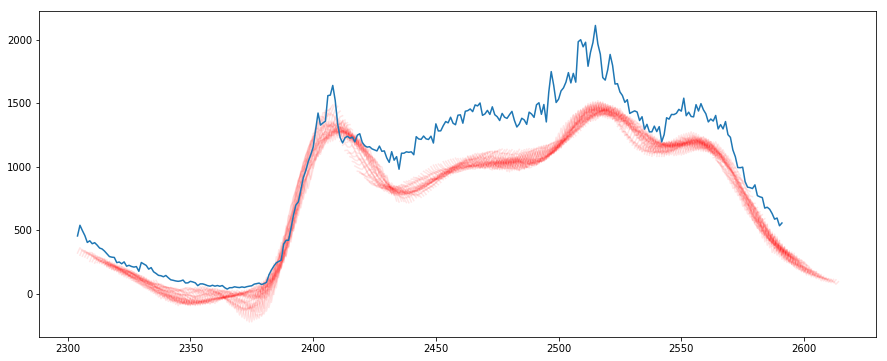

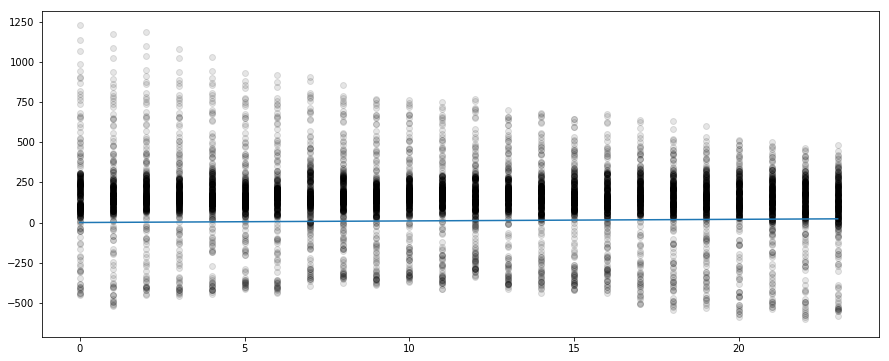

In [245]:
np.random.seed(6)

def over_penalty(y_true, y_pred):
    return K.square(y_true-y_pred)*K.square(K.sign(y_true-y_pred) - 0.7)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(1, look_back)))
model.add(Dense(look_forward))
model.compile(loss=over_penalty, optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

predict()

Epoch 1/5
5s - loss: 0.0023
Epoch 2/5
3s - loss: 0.0011
Epoch 3/5
3s - loss: 9.2909e-04
Epoch 4/5
3s - loss: 7.6049e-04
Epoch 5/5
3s - loss: 7.3555e-04
274.90 RMSE


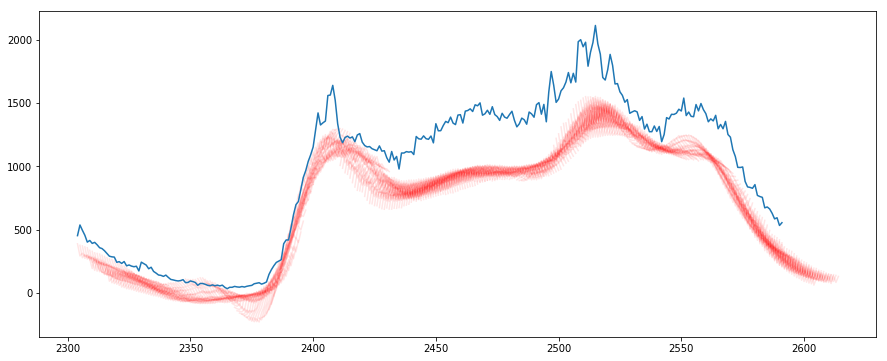

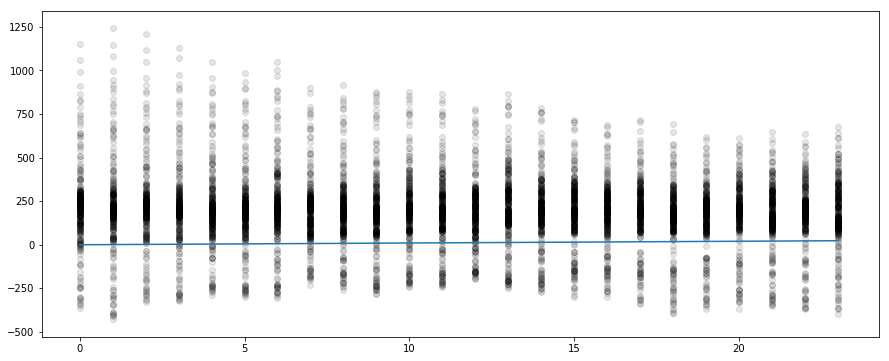

In [246]:
np.random.seed(6)

def over_penalty(y_true, y_pred):
    return K.square(y_true-y_pred)*K.square(K.sign(y_true-y_pred) - 0.8)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(1, look_back)))
model.add(Dense(look_forward))
model.compile(loss=over_penalty, optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

predict()

Epoch 1/5
5s - loss: 7.8360e-04
Epoch 2/5
4s - loss: 4.1427e-04
Epoch 3/5
3s - loss: 3.2669e-04
Epoch 4/5
3s - loss: 2.8769e-04
Epoch 5/5
3s - loss: 2.6365e-04
355.49 RMSE


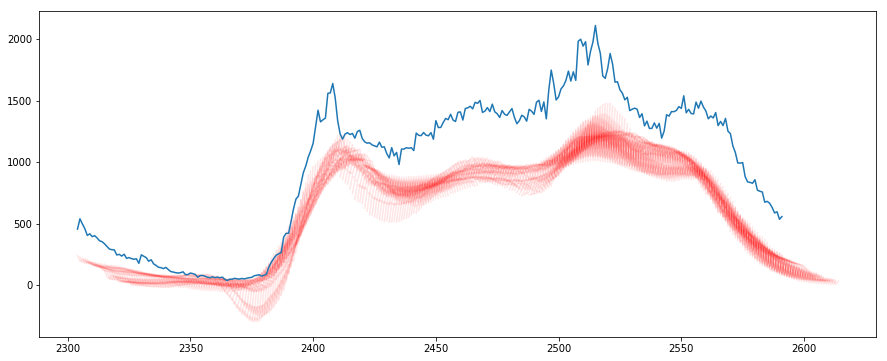

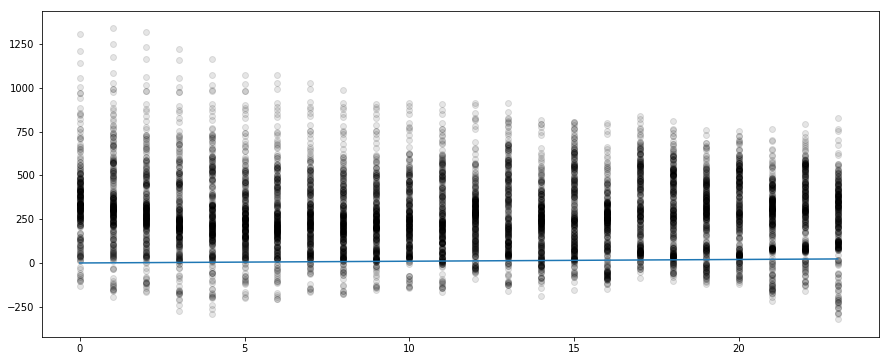

In [247]:
np.random.seed(6)

def over_penalty(y_true, y_pred):
    return K.square(y_true-y_pred)*K.square(K.sign(y_true-y_pred) - 0.9)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(1, look_back)))
model.add(Dense(look_forward))
model.compile(loss=over_penalty, optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

predict()

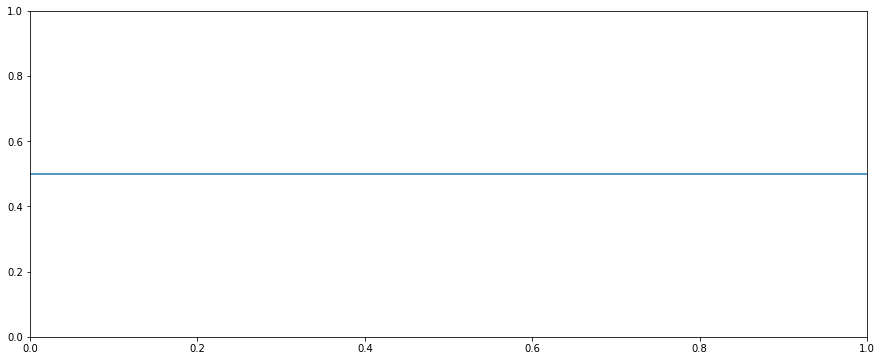

array(0)